<a href="https://colab.research.google.com/github/Thehunk1206/Covid-19-chest-X-ray/blob/master/Covid_CNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd drive/My\ Drive/Code19

/content/drive/My Drive/Code19


In [0]:
!tar -xzvf cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [0]:
!nvidia-smi

Mon Apr 13 06:06:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 64kB/s 
     |████████████████████████████████| 3.8MB 32.0MB/s 
     |████████████████████████████████| 450kB 46.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=fb2074462f636a4ede506f997d06db4df609671cf7f757ea74ca3233ff0baa1e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,\
    Dropout, Dense, Input, concatenate, ZeroPadding2D,  \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, add, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy
from tensorflow.keras.models import load_model

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import math  


import os
import numpy as np                                                                                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt

In [0]:
train_dir = "dataset/train"
validate_dir = "dataset/validate"
test_dir = "dataset/test"

num_of_train = 0
num_of_validate = 0
num_of_test = 0
for label in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,label)):
        num_of_train+=1

for label in os.listdir(validate_dir):
    for i in os.listdir(os.path.join(validate_dir,label)):
        num_of_validate+=1

for label in os.listdir(test_dir):
    for i in os.listdir(os.path.join(test_dir,label)):
        num_of_test+=1

print(f"Total training sample:{num_of_train}\n",f"Total validating sample:{num_of_validate}\n",f"Total test sample:{num_of_test}")

Total training sample:613
 Total validating sample:55
 Total test sample:65


In [0]:
IMG_SIZE = (256,256)
batch_size = 8
epoch = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=IMG_SIZE)

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validate_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE)

Found 613 images belonging to 3 classes.
Found 55 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


In [0]:
sample_test_images, labels = next(test_data_gen)
print(labels[0:10])
sample_test_images.shape

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


(8, 256, 256, 3)

# Displaying some samples

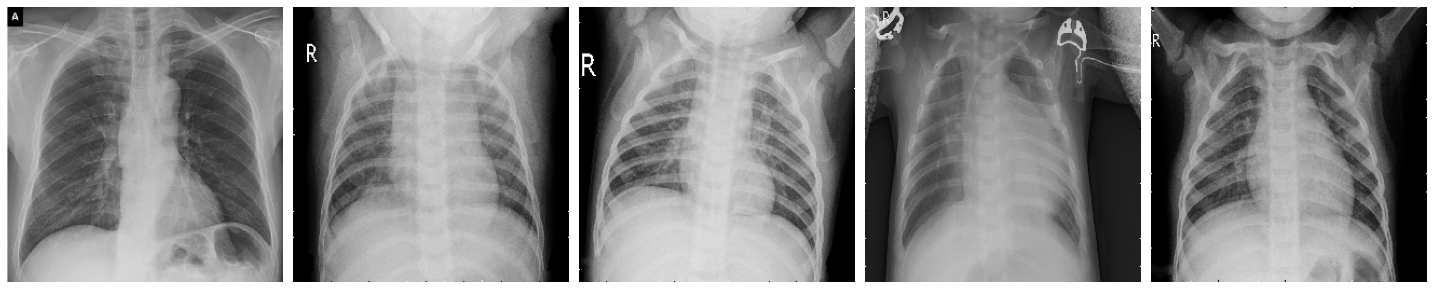

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [0]:
def plotImages(images_arr,labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(labels)
    

plotImages(sample_test_images[:5],labels[:5])



# model building

In [0]:
def residual_module(layer_in, n_filters,seq_strides=1,short_cut_stride=1):
    merge_input = layer_in
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    # conv2
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    short_cut = Conv2D(n_filters, (1,1), strides=short_cut_stride, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(merge_input)
    short_cut = BatchNormalization(axis=3)(short_cut)
    short_cut = Activation('linear')(short_cut)
    # add filters, assumes filters/channels last
    layer_out = add([x, short_cut])
    # activation function
    layer_out = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer_out)
    return layer_out

input_layer = Input(shape=(256,256,3))
x = residual_module(input_layer,16,seq_strides=2,short_cut_stride=4)
x = Activation('relu')(x)

x = residual_module(x,32)
x = Activation('relu')(x)
x = residual_module(x,32)
x = Activation('relu')(x)
x = residual_module(x,32)
x = Activation('relu')(x)

x = residual_module(x,48)
x = Activation('relu')(x)
x = residual_module(x,48)
x = Activation('relu')(x)
x = residual_module(x,48)
x = Activation('relu')(x)


x = residual_module(x,64)
x = Activation('relu')(x)
x = residual_module(x,64)
x = Activation('relu')(x)
x = residual_module(x,64)
x = Activation('relu')(x)


x = residual_module(x,128)
x = Activation('relu')(x)
x = residual_module(x,128)
x = Activation('relu')(x)
x = residual_module(x,128)
x = Activation('relu')(x)


x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2())(x)
output = Dense(3,activation='softmax')(x)

largecovidcnn = Model(inputs=input_layer,outputs=output)
largecovidcnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Visualizing model

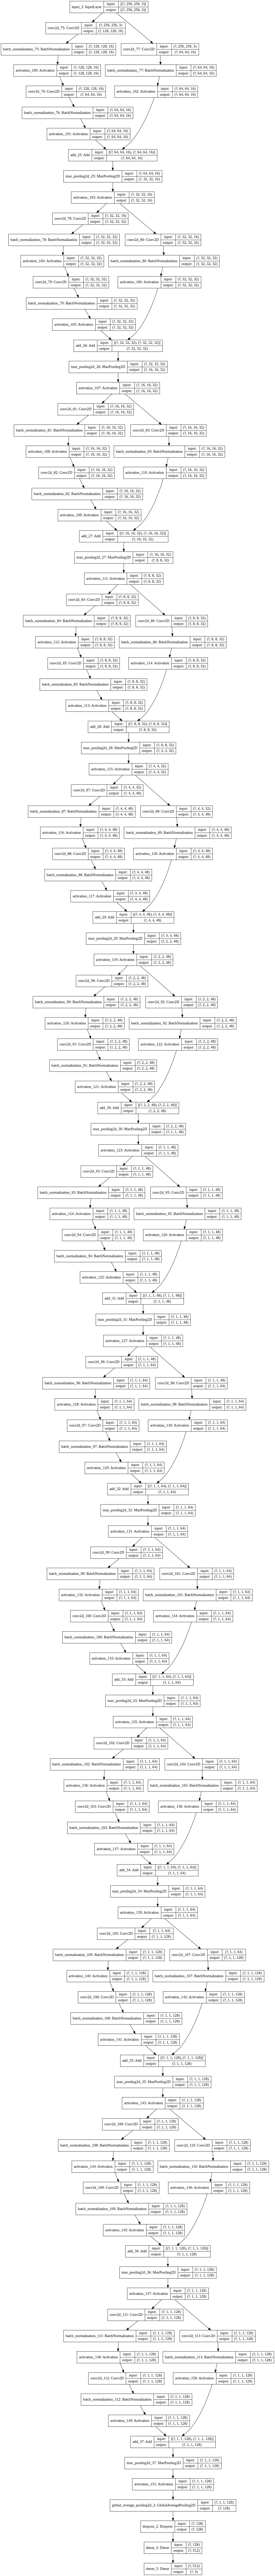

In [0]:
plot_model(largecovidcnn, show_shapes=True, to_file='largecovidcnn_161.png')

In [0]:
len(largecovidcnn.layers)

161

# Compiling model

In [0]:
initial_lrate = 0.00008


def decay(epoch, steps=100):
    initial_lrate = 0.00008
    drop = 0.96
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


opt = Adam(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)


largecovidcnn.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall()])

In [0]:
checkpoint = ModelCheckpoint("covid-19_large.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto')
callback = [checkpoint,lr_sc]
hist = largecovidcnn.fit_generator(generator=train_data_gen, validation_data= test_data_gen, epochs=epoch,callbacks=callback)

76/77 [============================>.] - ETA: 0s - loss: 52.0098 - accuracy: 0.3322 - auc: 0.5225 - precision: 0.3377 - recall: 0.2579
Epoch 00003: val_accuracy did not improve from 0.44615
77/77 [==============================] - 29s 375ms/step - loss: 51.9988 - accuracy: 0.3295 - auc: 0.5195 - precision: 0.3348 - recall: 0.2561 - val_loss: 50.3134 - val_accuracy: 0.3846 - val_auc: 0.5346 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00004: LearningRateScheduler reducing learning rate to 8e-05.
Epoch 4/150
76/77 [============================>.] - ETA: 0s - loss: 49.1678 - accuracy: 0.3785 - auc: 0.5735 - precision: 0.3857 - recall: 0.2843
Epoch 00004: val_accuracy did not improve from 0.44615
77/77 [==============================] - 29s 382ms/step - loss: 49.1516 - accuracy: 0.3817 - auc: 0.5754 - precision: 0.3880 - recall: 0.2855 - val_loss: 47.7118 - val_accuracy: 0.4154 - val_auc: 0.5707 - val_precision: 0.5000 - val_recall: 0.0308

Epoch 00005: LearningRateScheduler

# Plotting Results

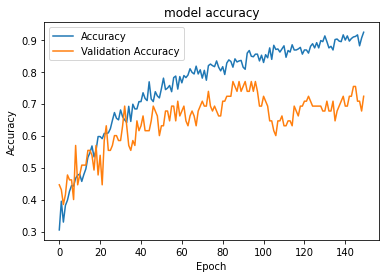

In [0]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

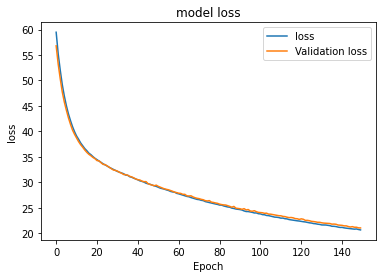

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()

## Model Evaluating

In [0]:
model = load_model('covid-19_large.h5')

In [0]:
model_metrics = model.evaluate(test_data_gen,verbose=1)

In [0]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [0]:
print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {model_metrics[3]}")
print(f"Recall: {model_metrics[4]}")
print(f"F1-score: {f1_score}")

Accuracy on test set: 76.92%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.85532546043396
Precision: 0.7692307829856873
Recall: 0.6153846383094788
F1-score: 0.6837607026100159


## Converting tf.keras model to tflite model

In [0]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("covidcnn_161.tflite" , "wb").write(tflite_model)

5319800